In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from fastai.data.external import untar_data, URLs
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

## 1- Dataset
We are using a subset of COCO from fastai (~21K images)

In [ ]:
IMG_SIZE = 256 # img resolution
SEED = 42

coco_path = untar_data(URLs.COCO_SAMPLE)
image_files = list((coco_path / 'train_sample').glob("*.jpg"))
print(f"Total images found in COCO_SAMPLE: {len(image_files)}")

np.random.seed(SEED)
np.random.shuffle(image_files)

# pick 10,000 images
N = min(len(image_files), 10000) # just in case it downloads less than 10K images, use min
image_files = image_files[:N]  # random (seeded) subset
print(f"Using {len(image_files)} images for demonstration.")

# 80/20 train/val split
split_idx = int(0.8 * len(image_files))
train_files = image_files[:split_idx]
val_files   = image_files[split_idx:]

print(f"Train set size: {len(train_files)}")
print(f"Val set size:   {len(val_files)}")

Total images found in COCO_SAMPLE: 21837
Using 10000 images for demonstration.
Train set size: 8000
Val set size:   2000


## 2- DATASET: On-the-fly LAB

In [ ]:
class LABDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # added small data augmentation, maybe add more later
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((IMG_SIZE, IMG_SIZE),  Image.BICUBIC) # only resize for validation set, dont do augmentation

        self.size = IMG_SIZE
        self.paths = paths
        self.split = split

    def __getitem__(self, idx):
        path = self.paths[idx]
        with Image.open(path).convert("RGB") as img:
            # Apply transformations
            img = self.transforms(img)
            # Convert PIL -> NumPy
            rgb_np = np.array(img)  # (H,W,3) in [0..255]

        # Convert RGB to LAB using skimage
        img_lab = rgb2lab(img).astype(np.float32)  # Convert to LAB
        L_channel, A_channel, B_channel = img_lab[..., 0], img_lab[..., 1], img_lab[..., 2]

        # Normalize L and AB channels
        L = torch.from_numpy(L_channel / 50.0 - 1.0).unsqueeze(0)  # Normalize L to [-1, 1] and add channel dimension
        ab = torch.from_numpy(np.stack((A_channel / 110.0, B_channel / 110.0), axis=0))  # Normalize AB to [-1, 1] and stack (We used 110 because we don't generally see extreme values like 128 and also some sources say this works better)

        # Output as dictionary
        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

In [ ]:
# dataloaders
train_ds = LABDataset(train_files, split='train')
val_ds   = LABDataset(val_files, split='val')

batch_size = 16
num_of_workers = 4
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_of_workers, pin_memory=True) # appearently pin memory can increase data speed from CPU to GPU
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_of_workers, pin_memory=True)

## Res-U-Net model

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    backbone = resnet18(pretrained=True) # resnet34 took longer and wasn't much better
    body = create_body(backbone, n_in=n_input, cut=-2) # cut the fully connected and pooling layers and take only the body
    model = DynamicUnet(body, n_output, (size, size)).to(device) # This automatically creates a U-Net model from the body
    return model

## Helper Functions

In [10]:
def lab_to_rgb(L, ab):
    """
    Convert normalized LAB channels back to RGB.
    - L in [-1, 1] -> [0, 100]
    - ab in [-1, 1] -> [-128, 127]
    Returns RGB images in [0, 1].
    """
    # Rescale L and AB channels
    L = (L + 1.) * 50.0  # Scale L to [0, 100]
    a = ab[:, [0], :, :] * 110.0  # Scale A back
    b = ab[:, [1], :, :] * 110.0  # Scale B back

    # Concatenate LAB and convert to RGB
    Lab = torch.cat([L, a, b], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = [lab2rgb(img.astype(np.float64)) for img in Lab]  # LAB -> RGB

    return np.stack(rgb_imgs, axis=0)  # Stack into a batch


def visualize_colorization(model, data, max_images=5, save=False):
    """
    Visualizes grayscale input (L), predicted colorization, and ground truth colorization.
    - max_images: Number of images to display (default: 5).
    - save: Whether to save the plot as a PNG file.
    """
    model.eval()
    with torch.no_grad():
        L_in = data['L'].to(device)  # Grayscale input
        ab_gt = data['ab'].to(device)  # Ground truth AB channels
        ab_pred = model(L_in)  # Predicted AB channels

    # Convert LAB to RGB
    rgb_fake = lab_to_rgb(L_in, ab_pred)
    rgb_real = lab_to_rgb(L_in, ab_gt)
    L_np = L_in.cpu().numpy()[:, 0, :, :]  # Extract L channel as NumPy array

    # Plot the results
    plt.figure(figsize=(15, 8))
    for i in range(min(max_images, L_in.size(0))):
        # Grayscale input (L channel)
        ax = plt.subplot(3, max_images, i + 1)
        ax.imshow(L_np[i], cmap='gray', vmin=-1, vmax=1)
        ax.set_title("L Input")
        ax.axis("off")

        # Predicted colorization
        ax = plt.subplot(3, max_images, i + 1 + max_images)
        ax.imshow(rgb_fake[i])
        ax.set_title("Predicted")
        ax.axis("off")

        # Ground truth colorization
        ax = plt.subplot(3, max_images, i + 1 + 2 * max_images)
        ax.imshow(rgb_real[i])
        ax.set_title("Ground Truth")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Save the plot if needed
    if save:
        plt.savefig(f"colorization_{time.time()}.png")


## Training Loop

In [ ]:
def train_model(
    model,
    train_dl,
    val_dl=None,
    epochs=5,
    lr=1e-4,
    criterion=None,
    visualize_val=True,
    vis_interval=3,
    save_path=None
):
    """
    Train a U-Net model for colorization with validation and optional model saving.

    Parameters:
      - model: The model to train.
      - train_dl: DataLoader for training data.
      - val_dl: DataLoader for validation data (optional).
      - epochs: Number of training epochs.
      - lr: Learning rate for the optimizer.
      - criterion: Loss function (default: nn.L1Loss).
      - visualize_val: Whether to visualize validation data predictions.
      - vis_interval: Interval (in epochs) to visualize predictions (default: 3).
      - save_path: Path to save the model after training (default: None).
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = criterion or nn.L1Loss()  # Default to L1 loss if none provided

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        sample_count = 0

        for batch in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
            L = batch['L'].to(device)  # Grayscale input
            ab = batch['ab'].to(device)  # Ground truth AB channels

            preds = model(L)
            loss = criterion(preds, ab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * L.size(0)
            sample_count += L.size(0)

        epoch_loss = running_loss / sample_count
        print(f"[Epoch {epoch+1}/{epochs}] Training Loss: {epoch_loss:.4f}")

        # Validation phase (calculates validation loss every epoch)
        if val_dl:
            model.eval()
            val_loss = 0.0
            val_sample_count = 0

            with torch.no_grad():
                for val_batch in val_dl:
                    L = val_batch['L'].to(device)
                    ab = val_batch['ab'].to(device)
                    preds = model(L)
                    loss = criterion(preds, ab)

                    val_loss += loss.item() * L.size(0)
                    val_sample_count += L.size(0)

            val_loss /= val_sample_count
            print(f"[Epoch {epoch+1}/{epochs}] Validation Loss: {val_loss:.4f}")

            # Visualization every vis_interval epochs
            if visualize_val and (epoch + 1) % vis_interval == 0:
                print(f"Visualizing predictions at epoch {epoch+1}...")
                visualize_colorization(model, val_batch, max_images=4)

    # Save the trained model if save_path is provided
    if save_path:
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        torch.save(model, save_path)
        print(f"Model saved to {save_path}")


In [3]:
def load_model(load_path, device='cuda'):
    """
    Load a PyTorch model (architecture + weights) from the specified path.

    Parameters:
      - load_path: Path to the saved model file.
      - device: Device to load the model onto ('cuda' or 'cpu').

    Returns:
      - model: The loaded PyTorch model.
    """
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Model file not found at {load_path}")

    model = torch.load(load_path, map_location=device)
    print(f"Model loaded from {load_path}")
    return model


In [ ]:
def continue_training(
    load_path,
    train_dl,
    val_dl=None,
    epochs=5,
    lr=1e-4,
    criterion=None,
    visualize_val=True,
    vis_interval=3,
    save_path=None
):
    """
    Load a saved model and continue training.

    Parameters:
      - load_path: Path to the saved model.
      - Other parameters are the same as `train_model`.
    """
    print("Loading model for continued training...")
    model = load_model(load_path, device=device)

    # Continue training using the `train_model` function
    train_model(
        model=model,
        train_dl=train_dl,
        val_dl=val_dl,
        epochs=epochs,
        lr=lr,
        criterion=criterion,
        visualize_val=visualize_val,
        vis_interval=vis_interval,
        save_path=save_path
    )

### Start training

In [ ]:
model = build_res_unet(n_input=1, n_output=2, size=IMG_SIZE)
print("U-Net model created.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


U-Net model created.


In [ ]:
EPOCHS = 20
LR = 1e-4

print("Starting training on random (seeded) COCO images...")
train_model(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=EPOCHS,
    lr=LR,
    save_path="/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/resUnet/resUnet_colorizer_coco.pt",
    vis_interval=3
)
print("Training complete.")

Output hidden; open in https://colab.research.google.com to view.

## Test on user images

In [4]:
def test_colorization(model, input_path, output_dir=None, img_size=256):
    """
    Test the colorization model on user-provided images or directories of images.

    Parameters:
      - model: Trained colorization model (already loaded).
      - input_path: Path to an image or directory containing images.
      - output_dir: Directory to save the colorized images (optional).
      - img_size: Image size to resize input images to (default: 256).
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Determine if input_path is an image or a directory
    input_path = Path(input_path)
    if input_path.is_file():  # Single image
        image_paths = [input_path]
    elif input_path.is_dir():  # Directory of images
        image_paths = list(input_path.glob("*.[pjJP][pnPN][gG]"))  # Match jpg, png, etc.
        image_paths = sorted(image_paths)  # Sort to ensure consistent order
    else:
        raise ValueError(f"Invalid input path: {input_path}")

    # Limit the number of images to visualize to 5
    visualize_images = image_paths[:5]
    visualize_only = len(image_paths) > 5 and output_dir is None

    # Ensure the output directory exists, if provided
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

    # Transformation for input images
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size), Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    # Process images
    for idx, img_path in enumerate(tqdm(image_paths, desc="Processing images")):
        # Load and preprocess the grayscale version
        grayscale_img = Image.open(img_path).convert("L")  # Open as grayscale
        L = transform(grayscale_img).unsqueeze(0).to(device)  # Add batch dimension and send to device

        # Load the ground truth (original RGB image)
        ground_truth_img = Image.open(img_path).convert("RGB")
        ground_truth_img_resized = ground_truth_img.resize((img_size, img_size), Image.BICUBIC)

        # Predict colorization
        with torch.no_grad():
            ab_pred = model(L)

        # Convert LAB to RGB
        L = L.cpu()
        ab_pred = ab_pred.cpu()
        rgb_fake = lab_to_rgb(L, ab_pred)[0]  # Extract the first (and only) image from the batch

        # Visualize the first 5 images
        if idx < 5:
            plt.figure(figsize=(15, 5))

            # Grayscale input
            plt.subplot(1, 3, 1)
            plt.imshow(L[0, 0].numpy(), cmap="gray", vmin=-1, vmax=1)
            plt.title("Grayscale Input")
            plt.axis("off")

            # Predicted colorization
            plt.subplot(1, 3, 2)
            plt.imshow(rgb_fake)
            plt.title("Predicted Colorization")
            plt.axis("off")

            # Ground truth (original color image)
            plt.subplot(1, 3, 3)
            plt.imshow(ground_truth_img_resized)
            plt.title("Ground Truth (Color)")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        # Save the processed image if output_dir is provided
        if output_dir:
            output_file = output_dir / img_path.name
            plt.imsave(output_file, rgb_fake)
            print(f"Saved colorized image to {output_file}")

        # Skip further processing if only visualizing
        if visualize_only and idx >= 4:
            break


In [ ]:
# model = load_model("/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/resUnet/resUnet_colorizer_coco.pt", device=device)

<ipython-input-10-58879b1ecf1f>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(load_path, map_location=device)


Model loaded from /content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/resUnet/resUnet_colorizer_coco.pt


In [ ]:
input_path = "/content/test_images"
test_colorization(model, input_path)

Output hidden; open in https://colab.research.google.com to view.

#### Train for 20 more epochs

In [ ]:
EPOCHS = 20
LR = 1e-4

print("Starting training on random (seeded) COCO images...")
train_model(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=EPOCHS,
    lr=LR,
    save_path="/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/resUnet/resUnet_colorizer_coco40.pt",
    vis_interval=3
)
print("Training complete.")

Output hidden; open in https://colab.research.google.com to view.

#### Test the 40 epoch model on user images

In [7]:
model = load_model("/content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/resUnet/resUnet_colorizer_coco40.pt", device=device)

<ipython-input-3-f92a412d9f9a>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(load_path, map_location=device)


Model loaded from /content/drive/MyDrive/Okul/Eğitim/Ders/5. Dönem/YZV 303E - Deep Learning/Project/models/resUnet/resUnet_colorizer_coco40.pt


Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

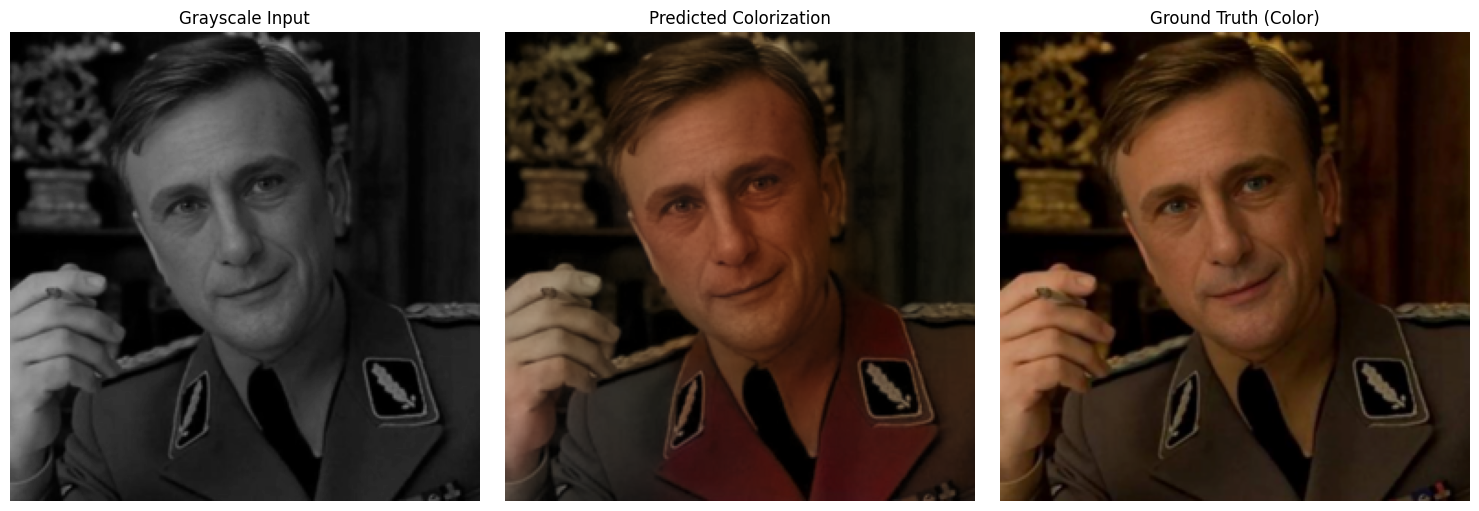

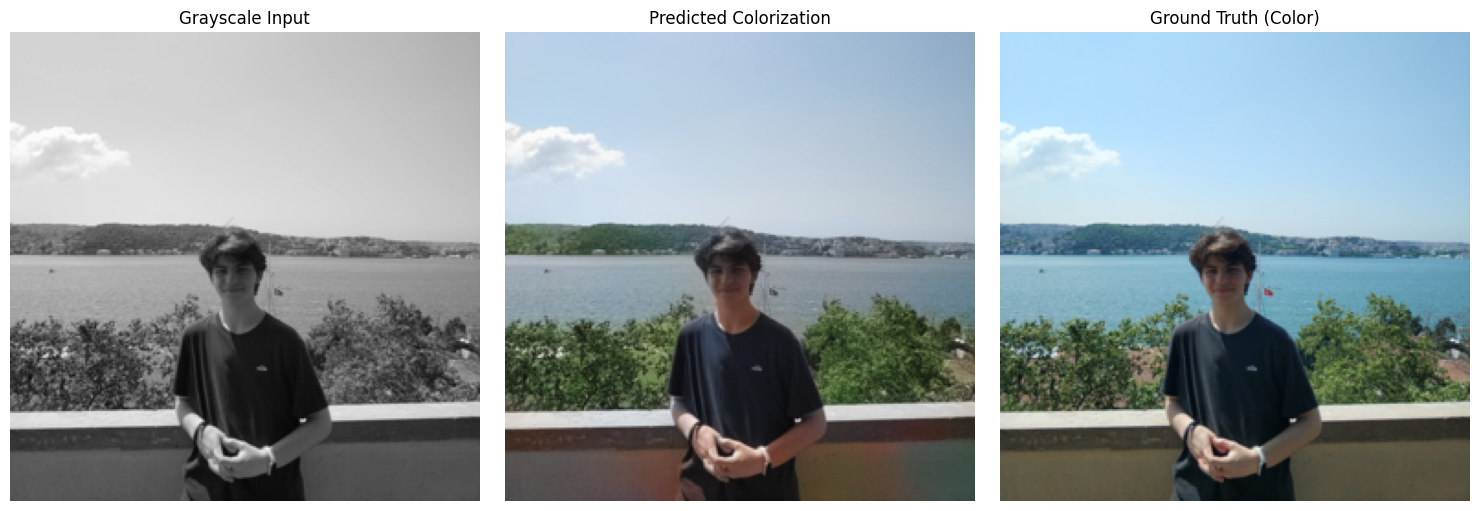

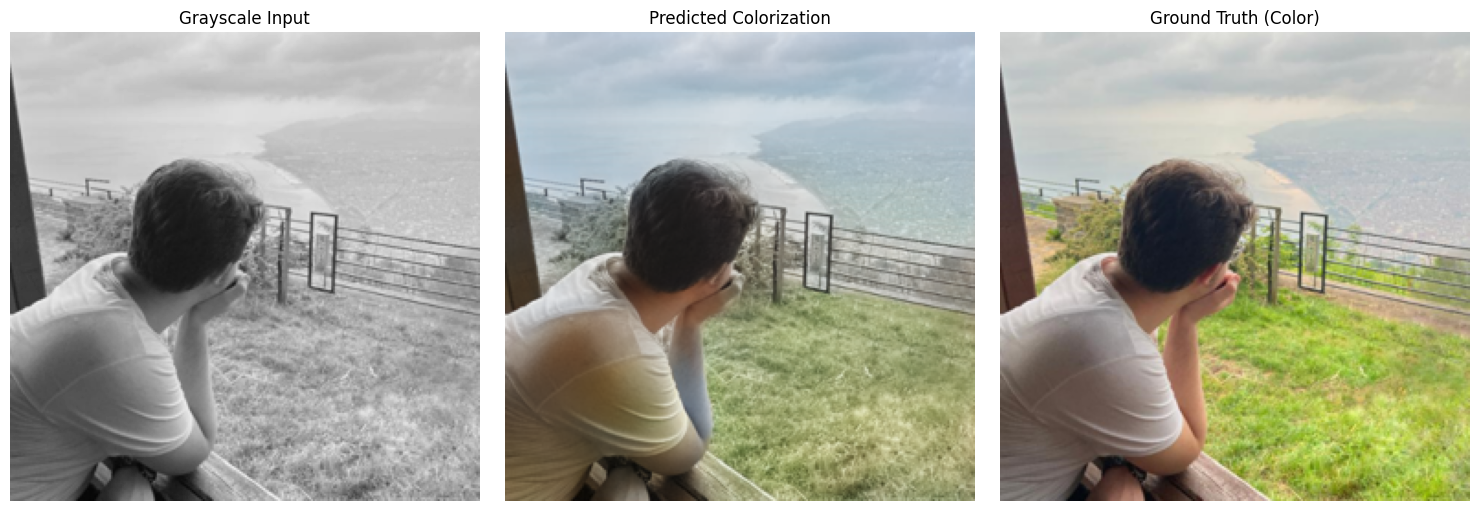

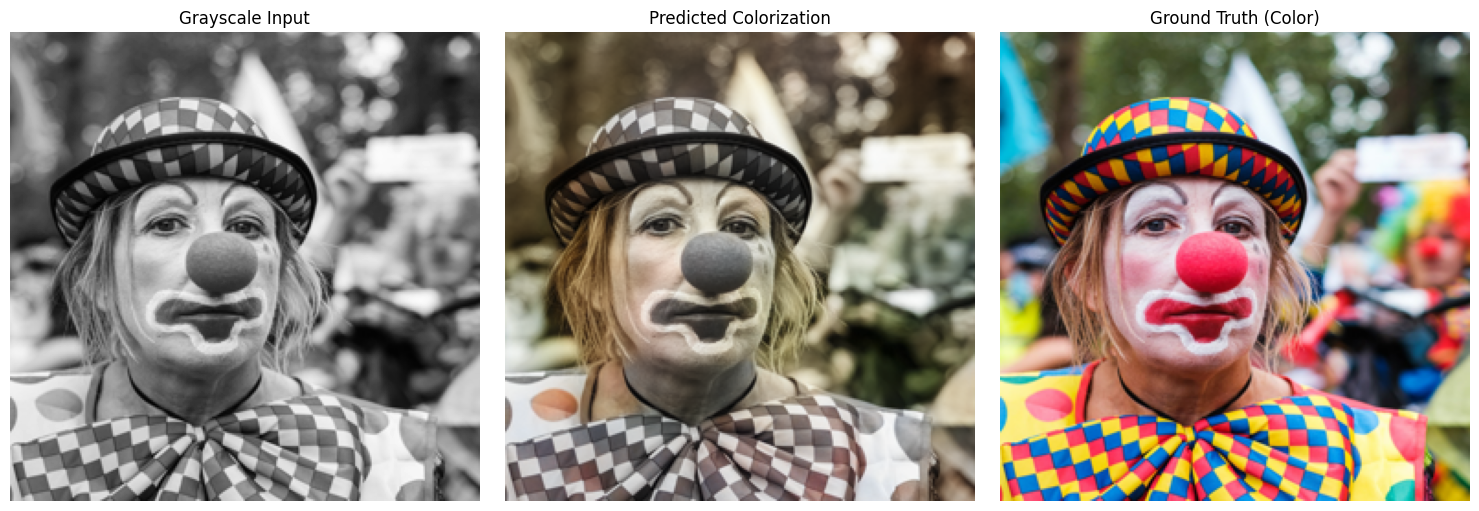

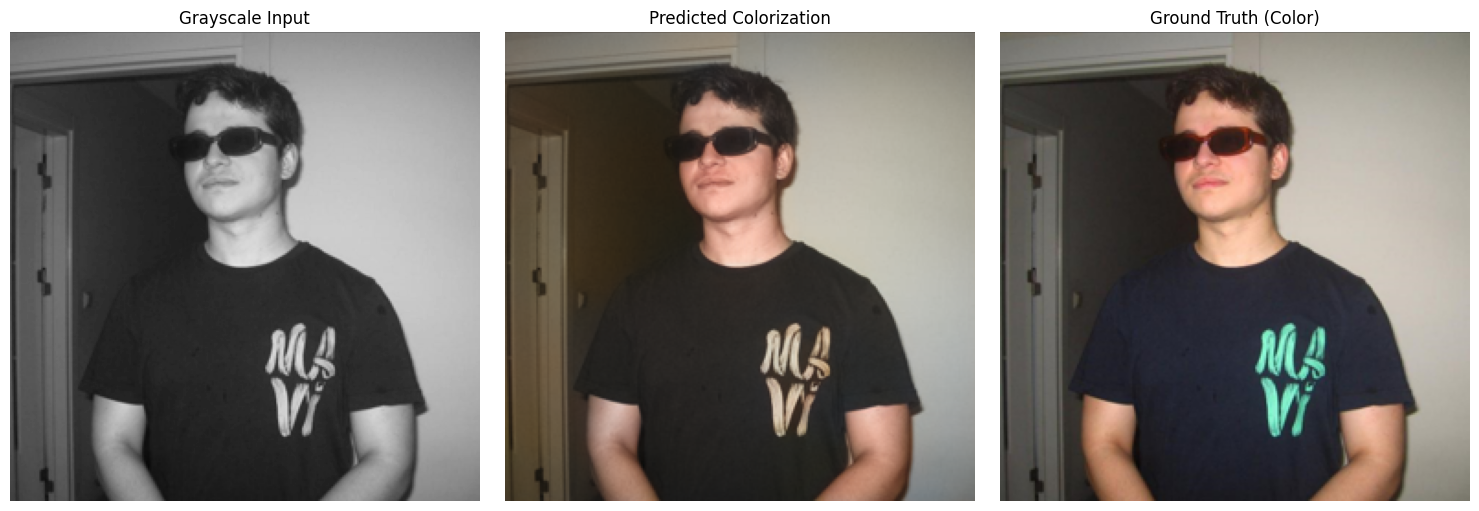

In [12]:
input_path = "/content/test_images"
test_colorization(model, input_path)